### Confirm Tensorflow Installation

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


### Importing the necessary modules

In [2]:
import numpy as np
import pandas as pd
import os
import glob
from os import listdir
from os.path import isfile, join
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/deep_final/training.zip' -d '/content/drive/My Drive/deep_final/training'


### Loading and Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/deep_final/training'
fnames = glob.glob(data_path + '/*.jpg')

print("found",len(fnames),"jpg files.")

Mounted at /content/drive
found 2190 jpg files.


在讀進label_tab時就要分train, test比較方便  
方法：shuffle後，每個類別前6 train, 後4 test

In [10]:
label_tab = pd.read_csv(data_path + '/label.csv')
label_tab = label_tab.sample(frac = 1)
label_tab = label_tab.sort_values(by = 'category').reset_index(drop=True)

In [11]:
train_tab = pd.DataFrame(columns = ['filename', 'category'])
valid_tab = pd.DataFrame(columns = ['filename', 'category'])

for i in np.arange(max(label_tab['category']) + 1):
    train_tab = pd.concat([train_tab, label_tab[label_tab['category'] == i].reset_index(drop=True).iloc[:6, :]])
    valid_tab = pd.concat([valid_tab, label_tab[label_tab['category'] == i].reset_index(drop=True).iloc[6:, :]])

train_tab = train_tab.reset_index(drop=True)
valid_tab = valid_tab.reset_index(drop=True)

print('train_tab :', train_tab.shape)
print('valid_tab :', valid_tab.shape)

train_tab : (1314, 2)
valid_tab : (876, 2)


In [62]:
#Load image
x_train = []
x_valid = []

for i in range(train_tab.shape[0]):
    file_ = data_path + '/' + train_tab.at[i, 'filename']
    img = cv2.imread(file_,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # 方形
    x_train.append(img)

for i in range(valid_tab.shape[0]):
    file_ = data_path + '/' + valid_tab.at[i, 'filename']
    img = cv2.imread(file_,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # 方形
    x_valid.append(img)

print(np.array(x_train).shape)
print(np.array(x_valid).shape)

(1314, 128, 128, 3)
(876, 128, 128, 3)


In [63]:
#Load label
y_train = []
y_valid = []

for i in range(train_tab.shape[0]):
    label_ = train_tab.at[i, 'category']
    y_train.append(label_)

for i in range(valid_tab.shape[0]):
    label_ = valid_tab.at[i, 'category']
    y_valid.append(label_)

print(np.array(y_train).shape)
print(np.array(y_valid).shape)

(1314,)
(876,)


In [64]:
for i in range(train_tab.shape[0]):
    x_train.append(cv2.flip(x_train[i], 0))
    y_train.append(y_train[i])

for i in range(train_tab.shape[0]):
    x_train.append(cv2.flip(x_train[i], 1))
    y_train.append(y_train[i])

for i in range(train_tab.shape[0]):
    x_train.append(cv2.flip(x_train[i], -1))
    y_train.append(y_train[i])

for i in range(train_tab.shape[0]):
    rotate = cv2.getRotationMatrix2D((x_train[i].shape[0]/2, x_train[i].shape[1]/2), 45, 1)
    x_train.append(cv2.warpAffine(x_train[i], rotate, (x_train[i].shape[0], x_train[i].shape[1])))
    y_train.append(y_train[i])
'''
for i in range(train_tab.shape[0]):
    rotate = cv2.getRotationMatrix2D((x_train[i].shape[0]/2, x_train[i].shape[1]/2), 135, 1)
    x_train.append(cv2.warpAffine(x_train[i], rotate, (x_train[i].shape[0], x_train[i].shape[1])))
    y_train.append(y_train[i])

for i in range(train_tab.shape[0]):
    rotate = cv2.getRotationMatrix2D((x_train[i].shape[0]/2, x_train[i].shape[1]/2), 225, 1)
    x_train.append(cv2.warpAffine(x_train[i], rotate, (x_train[i].shape[0], x_train[i].shape[1])))
    y_train.append(y_train[i])
'''
for i in range(train_tab.shape[0]):
    rotate = cv2.getRotationMatrix2D((x_train[i].shape[0]/2, x_train[i].shape[1]/2), 315, 1)
    x_train.append(cv2.warpAffine(x_train[i], rotate, (x_train[i].shape[0], x_train[i].shape[1])))
    y_train.append(y_train[i])

for i in range(train_tab.shape[0]):
    b, g, r = cv2.split(x_train[i])
    
    dstb = np.zeros_like(b)
    b1 = cv2.normalize(b, dstb, 0, 255, cv2.NORM_MINMAX)
    dstg = np.zeros_like(g)
    g1 = cv2.normalize(g, dstg, 0, 255, cv2.NORM_MINMAX)
    dstr = np.zeros_like(r)
    r1 = cv2.normalize(r, dstr, 0, 255, cv2.NORM_MINMAX)

    x_train.append(cv2.merge([b1,g1,r1]))
    y_train.append(y_train[i])

print(np.array(x_train).shape)
print(np.array(y_train).shape)

(9198, 128, 128, 3)
(9198,)


In [65]:
# 轉 0/1
from tensorflow.keras.utils import to_categorical

# to array

x_train = np.array(x_train)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

# 轉 0/1
#Convert a category vector to a binary (0 or 1) matrix-type representation
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

print(np.array(y_train).shape)
print(np.array(y_valid).shape)

(9198, 219)
(876, 219)


In [ ]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 45,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True)

datagen.fit(x_train)
datagen.fit(x_valid)

print(x_train.shape)
print(x_valid.shape)

'''


'\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\ndatagen = ImageDataGenerator(\n    featurewise_center = True,\n    featurewise_std_normalization = True,\n    rotation_range = 45,\n    width_shift_range = 0.3,\n    height_shift_range = 0.3,\n    horizontal_flip = True,\n    vertical_flip = True)\n\ndatagen.fit(x_train)\ndatagen.fit(x_valid)\n\nprint(x_train.shape)\nprint(x_valid.shape)\n\n'

### Show the image

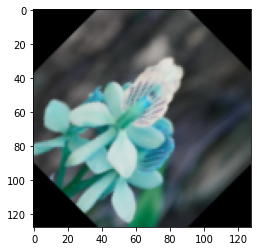

Answer: 31
Answer(one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [94]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, x_train.shape[0])
plt.imshow(x_train[idx])
plt.show()

print("Answer:", np.argmax(y_train[idx]))
print("Answer(one-hot):", y_train[idx])

### Build the network

You can show the detail for it:

In [101]:
'''
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128, 128, 3),
    pooling='avg'
#    classes=219
)

model = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128, 128, 3),
    pooling='avg'
#    classes=219
)

'''
model = tf.keras.applications.xception.Xception( # 65
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128, 128, 3),
    pooling='avg'
)

x = model.output
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Dense(219, activation='softmax')(x)

model_final = tf.keras.models.Model(inputs = model.input, outputs = output_layer)



In [102]:
print(model_final.summary())

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_13[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

### Training the network

In [103]:
epoch = 50

model_final.compile(
    loss="categorical_crossentropy", 
    optimizer="sgd", 
    metrics=["accuracy"]
)

'''
history = model_final.fit(datagen.flow(x_train, y_train, batch_size = 8), 
         validation_data = datagen.flow(x_valid, y_valid, batch_size = 4), 
         epochs = epoch)

'''

history = model_final.fit(x_train, y_train, 
         validation_data = (x_valid, y_valid), 
         batch_size = 32, epochs = epoch)

Epoch 1/50
288/288 [==============================] - 45s 139ms/step - loss: 5.5252 - accuracy: 0.0190 - val_loss: 4.3901 - val_accuracy: 0.1210
Epoch 2/50
288/288 [==============================] - 39s 134ms/step - loss: 4.1742 - accuracy: 0.1334 - val_loss: 3.3915 - val_accuracy: 0.2660
Epoch 3/50
288/288 [==============================] - 38s 132ms/step - loss: 3.1447 - accuracy: 0.3071 - val_loss: 2.8340 - val_accuracy: 0.3596
Epoch 4/50
288/288 [==============================] - 39s 134ms/step - loss: 2.4233 - accuracy: 0.4527 - val_loss: 2.4736 - val_accuracy: 0.4075
Epoch 5/50
288/288 [==============================] - 38s 133ms/step - loss: 1.8781 - accuracy: 0.5719 - val_loss: 2.2415 - val_accuracy: 0.4509
Epoch 6/50
288/288 [==============================] - 38s 132ms/step - loss: 1.4346 - accuracy: 0.6780 - val_loss: 2.0933 - val_accuracy: 0.4966
Epoch 7/50
288/288 [==============================] - 38s 133ms/step - loss: 1.1027 - accuracy: 0.7557 - val_loss: 1.9409 - val_ac

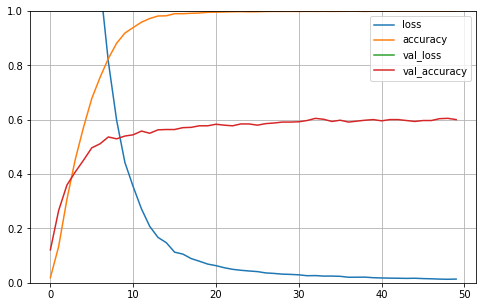

28/28 [==============================] - 1s 33ms/step - loss: 1.7312 - accuracy: 0.6005
Predict probabilities: [[0.47 0.   0.2  ... 0.01 0.   0.42]
 [0.87 0.31 0.13 ... 0.06 0.   0.1 ]
 [0.   0.   0.72 ... 0.   0.   0.  ]]
Predict answers: [1972 1361 1721]


In [104]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

model_final.evaluate(x_valid, y_valid)

x_new = x_valid[:3]
y_predict = model.predict(x_new)
print("Predict probabilities:", y_predict.round(2))
print("Predict answers:", y_predict.argmax(axis=1))

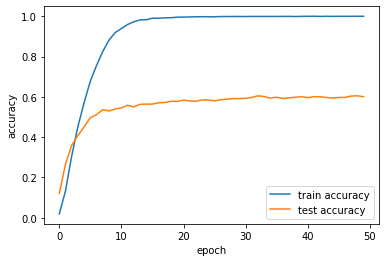

In [105]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','test accuracy'])
plt.show()

### Saving the trained weights

In [106]:
model_final.save("my_model.hdf5")

In [107]:
from tensorflow.keras.models import load_model
model_final_2 = load_model("/content/drive/My Drive/deep_final/my_model.hdf5")

In [108]:
model_final_2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_13[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [109]:
y_hat = model_final_2.predict(x_valid)

In [110]:
# 將output改為標籤
output_y = np.zeros(y_hat.shape[0])

for i in range(y_hat.shape[0]):
    for j in range(y_hat.shape[1]):
        if y_hat[i, j] >= max(y_hat[i, ]):
            output_y[i] = j

output_y

array([ 59.,  59.,   0.,   0.,   1.,   1.,   1.,   1.,   2., 202.,   2.,
         2., 181.,  49.,  80.,  42., 194.,   4.,   4.,   3., 143.,  95.,
       158.,  12.,   6.,   6.,   6.,   6.,   7., 149.,   7., 147.,   8.,
         8.,   8.,   8.,   9., 169.,   7.,  77.,  10.,  26.,   4.,  48.,
        11.,  97.,  11., 129.,  12.,  12., 158., 144.,  91.,  13., 128.,
       128.,  14.,  14.,  14.,  14., 122., 165.,  43.,  23.,  16.,  16.,
        16.,  16.,  17.,  17.,  14.,  17.,  18.,  18., 130.,  18.,  19.,
        19.,  19.,  19., 109.,  21., 109., 109.,  21.,  21.,  21.,  21.,
        22.,  22.,  22.,  22.,  23., 136.,  23.,  43.,  24.,  61.,  24.,
        24.,  25.,  25.,  61., 184., 201.,  80.,  26.,  26., 170.,  60.,
       126.,  92.,  28.,  28., 126., 126.,  29.,  29., 154.,  29.,  30.,
        30., 164.,  30., 152.,  31.,  31., 144.,  24., 137., 142.,  24.,
        86.,  33.,  33.,  86.,  34., 177.,  34.,  34.,  35.,   2.,  35.,
         2.,  36.,  36.,  36.,  36.,  85.,  37., 21

In [111]:
output_yv = np.zeros(y_valid.shape[0])

for i in range(y_valid.shape[0]):
    for j in range(y_valid.shape[1]):
        if y_valid[i, j] >= max(y_valid[i, ]):
            output_yv[i] = j

output_yv

array([  0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,
         2.,   3.,   3.,   3.,   3.,   4.,   4.,   4.,   4.,   5.,   5.,
         5.,   5.,   6.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   8.,
         8.,   8.,   8.,   9.,   9.,   9.,   9.,  10.,  10.,  10.,  10.,
        11.,  11.,  11.,  11.,  12.,  12.,  12.,  12.,  13.,  13.,  13.,
        13.,  14.,  14.,  14.,  14.,  15.,  15.,  15.,  15.,  16.,  16.,
        16.,  16.,  17.,  17.,  17.,  17.,  18.,  18.,  18.,  18.,  19.,
        19.,  19.,  19.,  20.,  20.,  20.,  20.,  21.,  21.,  21.,  21.,
        22.,  22.,  22.,  22.,  23.,  23.,  23.,  23.,  24.,  24.,  24.,
        24.,  25.,  25.,  25.,  25.,  26.,  26.,  26.,  26.,  27.,  27.,
        27.,  27.,  28.,  28.,  28.,  28.,  29.,  29.,  29.,  29.,  30.,
        30.,  30.,  30.,  31.,  31.,  31.,  31.,  32.,  32.,  32.,  32.,
        33.,  33.,  33.,  33.,  34.,  34.,  34.,  34.,  35.,  35.,  35.,
        35.,  36.,  36.,  36.,  36.,  37.,  37.,  3

In [112]:
sum(output_y == output_yv) / len(output_y)

0.6004566210045662